## Heart anomaly detection using Autoencoders

The idea is to detect cardiac anomalies using deep learning and more specific Autoencoders.

Using ECG data
I.e:
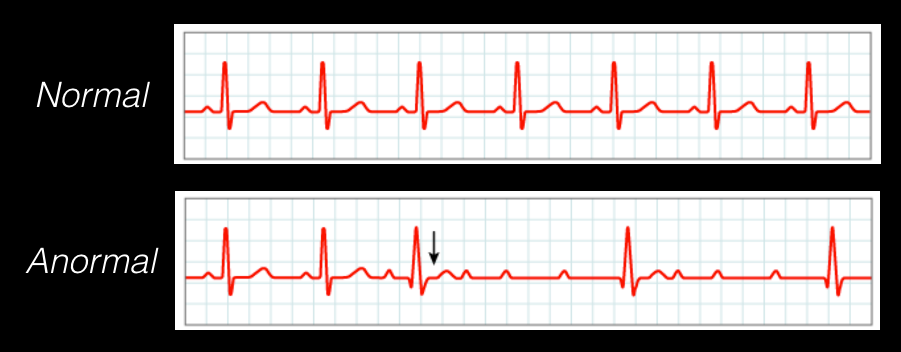



### Dataset description:
- ECG5000 with 7600 training and 1900 test samples.
- Highly unbalanced data. This is why we choose Autoencoder for anomaly detection.
- 5 possibles categories:
    - Normal
    - Early Ventricular contraction
    - Early supraVentricular contraction
    - Latido ectopico
    - Undefined anomaly
    
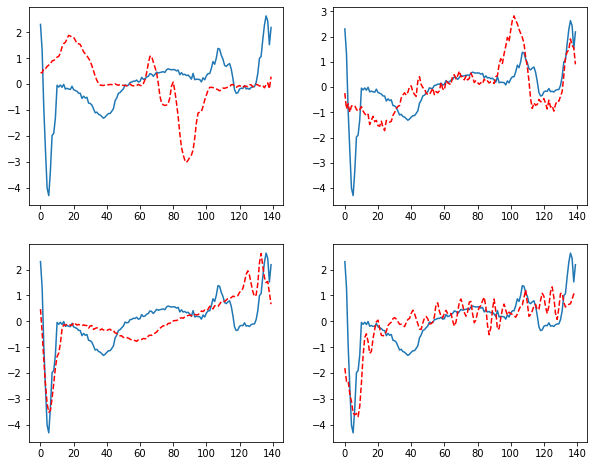

- ECG5000:
    - 4427 normal records and 3173 anomalies
    - Every record is composed by 143 values, this are the values recorded during a specific measurement

Library import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import confusion_matrix, precision_recall_curve
np.random.seed(23)
tf.enable_eager_execution()

Dataset import

In [2]:
train_data = pd.read_csv('../Datasets/cardiac_anomalies/ECG5000_train.csv')
test_data = pd.read_csv('../Datasets/cardiac_anomalies/ECG5000_test.csv')

Concatenate 2 test/train dataset for EDA

In [3]:
dataframe = pd.concat([train_data, test_data], ignore_index= True)
dataframe.head(5)

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1,-1.30300,-0.83573,-1.9336,-2.09420,-2.02840,-1.2531,-0.52638,-0.089286,-0.07557,...,-1.45820,-1.6676,-1.5977,-1.67930,-1.677200,-1.69370,-1.79410,-1.35940,-2.08120,-2.82880
1,2,0.32288,-0.87847,-1.8023,-2.66850,-3.26550,-3.3326,-2.88000,-2.227400,-1.54360,...,-1.23050,-1.7218,-2.1953,-2.74890,-3.446500,-3.66210,-3.01820,-1.65140,-0.23670,0.82832
2,2,1.39340,1.59260,1.2420,0.79449,0.19577,-0.3156,-0.58053,-0.945020,-1.23350,...,-1.90850,-2.5295,-3.0614,-3.50370,-3.900400,-4.24600,-4.13380,-3.19850,-2.42200,-1.07370
3,1,-3.52270,-5.02610,-4.3613,-4.10570,-3.10420,-1.8178,-1.39840,-1.070100,-0.40691,...,0.83038,1.0084,1.1830,0.94636,0.952130,0.79343,0.84741,1.01390,0.31234,-2.19060
4,1,-1.91820,-3.22510,-3.4652,-4.00800,-3.87030,-3.3581,-2.28540,-1.728500,-1.42220,...,1.77690,1.5029,1.1651,0.46073,0.019172,-0.32739,-0.48051,-0.18814,0.14284,-0.66844


## Exploratory Data Analysis

Label exploration:

In [ ]:
dataframe['0'].value_counts()

Category '1' is related to normal events. The others for anomalies.
Lets create a new feature with 0 for any normal event and 1 for every anomaly.

In [4]:
dataframe['label'] = 1
dataframe.loc[(dataframe['0'] == 1), 'label'] = 0
dataframe.head(5)

,0,1,2,3,4,5,6,7,8,9,...,132,133,134,135,136,137,138,139,140,label
0,1,-1.30300,-0.83573,-1.9336,-2.09420,-2.02840,-1.2531,-0.52638,-0.089286,-0.07557,...,-1.6676,-1.5977,-1.67930,-1.677200,-1.69370,-1.79410,-1.35940,-2.08120,-2.82880,0
1,2,0.32288,-0.87847,-1.8023,-2.66850,-3.26550,-3.3326,-2.88000,-2.227400,-1.54360,...,-1.7218,-2.1953,-2.74890,-3.446500,-3.66210,-3.01820,-1.65140,-0.23670,0.82832,1
2,2,1.39340,1.59260,1.2420,0.79449,0.19577,-0.3156,-0.58053,-0.945020,-1.23350,...,-2.5295,-3.0614,-3.50370,-3.900400,-4.24600,-4.13380,-3.19850,-2.42200,-1.07370,1
3,1,-3.52270,-5.02610,-4.3613,-4.10570,-3.10420,-1.8178,-1.39840,-1.070100,-0.40691,...,1.0084,1.1830,0.94636,0.952130,0.79343,0.84741,1.01390,0.31234,-2.19060,0
4,1,-1.91820,-3.22510,-3.4652,-4.00800,-3.87030,-3.3581,-2.28540,-1.728500,-1.42220,...,1.5029,1.1651,0.46073,0.019172,-0.32739,-0.48051,-0.18814,0.14284,-0.66844,0


Now we can see the distribution of the events along the data

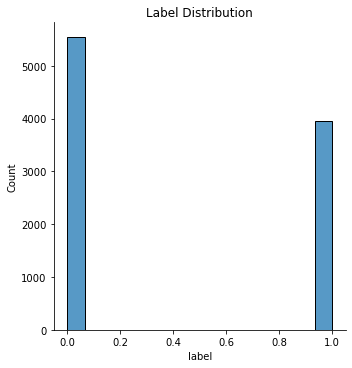

Number of Anormal records: 3954

Number of Normal records: 5546

Proportion of Normal vs Anomalies: 0.712946267580238


In [5]:
sns.displot(dataframe.label)
plt.title('Label Distribution')
plt.show()

normal_record = dataframe.loc[(dataframe.label == 1), 'label'].value_counts().sum()
anormal_record = dataframe[(dataframe.label == 0)].label.value_counts().sum()

print('Number of Anormal records: {}'.format(normal_record))
print('\nNumber of Normal records: {}'.format(anormal_record))
print('\nProportion of Normal vs Anomalies: {}'.format(normal_record/anormal_record))


Data is slightly unbalanced. In general we can balance the data using different methods, but in this case we're going to use it just like this due Autoencoders doesn't have problem with unbalanced data as every other deep learning method.

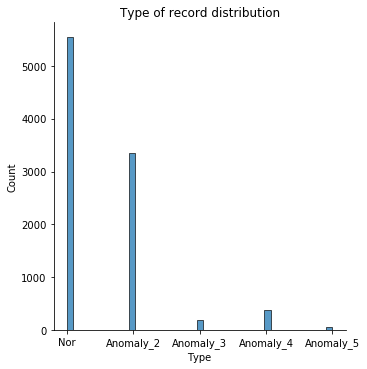

In [6]:
sns.displot(dataframe['0'])
plt.xticks([1,2,3,4,5],['Nor','Anomaly_2','Anomaly_3','Anomaly_4','Anomaly_5'])
plt.title('Type of record distribution')
plt.xlabel('Type')
plt.show()

Despite the unbalance in the normal vs anomaly events we have a lot of variation inside of the anomalies.
Type 2 seems to be the most frequent in our dataset, meanwhile type 3, 4 and 5 are less frequent representing almost 10% of the total amount of anormal records.

Let's look if the train/test data proportion and distribution and compare with the total dataset balance.

In [7]:
train_records = train_data.shape[0]
test_records = test_data.shape[0]
split_proportion = test_records/train_records

print('Train/test dataset split propotion: {}'.format(split_proportion))

Train/test dataset split propotion: 0.25


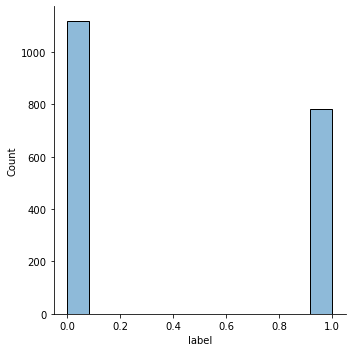

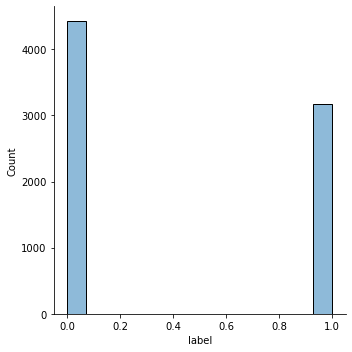

In [8]:
#'label' feature creation for both train and test datasets
train_data['label'] = 1
train_data.loc[(train_data['0'] == 1), 'label'] = 0

test_data['label'] = 1
test_data.loc[(test_data['0'] == 1), 'label'] = 0

sns.displot(test_data.label, alpha = 0.5)
sns.displot(train_data.label, alpha = 0.5)
plt.show()

Train and test datasets seems to be equal distributed. This is what we need.

Single record visualization.

Records are normalized, and every column represent a instant of time in which a measurement was made.

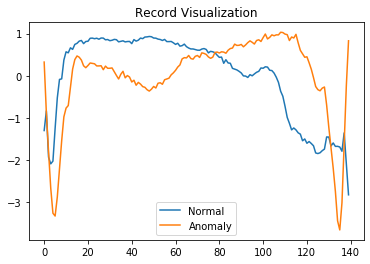

In [9]:
normal_values = dataframe.iloc[0,1:-1].values
anormal_values = dataframe.iloc[1,1:-1].values
time = np.arange(140)
plt.plot(time, normal_values, label = 'Normal')
plt.plot(time, anormal_values, label = 'Anomaly')
plt.title('Record Visualization')
plt.legend()
plt.show()

In [ ]:
 dataframe.iloc[0,1:-1].values

### Feature Engineering

Train and test feature and label creation

In [41]:
y_train = train_data['label']
y_test = test_data['label']

x_train = train_data.loc[train_data.label == 0].drop(['0', 'label'], axis = 1)
x_test = test_data.drop(['0', 'label'], axis = 1)

x_test_normal = test_data.loc[test_data.label == 0].drop(['0', 'label'], axis = 1)
x_test_anomaly = test_data.loc[test_data.label == 1].drop(['0', 'label'], axis = 1)

Data normalization

In [42]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_test_normal = scaler.transform(x_test_normal)
x_test_anomaly = scaler.transform(x_test_anomaly)

## Model definition

Autoencoder

In [43]:
input_dim = x_train.shape[1]

#Input layer
input_layer = Input(shape = (input_dim, ))

#Encoder
encoder = Dense(32, activation = 'relu')(input_layer)
encoder = Dense(16, activation = 'relu')(encoder)
encoder = Dense(8, activation = 'relu')(encoder)

#Decoder
decoder = Dense(16, activation = 'relu')(encoder)
decoder = Dense(32, activation = 'relu')(decoder)

#Output layer
output_layer = Dense(input_dim, activation = 'sigmoid')(decoder)

#
autoencoder = Model(inputs = input_layer,
                    outputs = output_layer)

autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                4512      
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_33 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_34 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_35 (Dense)             (None, 140)               4620

#### Training

Mean obsolute error (MAE) will be our training metric.

In [44]:
autoencoder.compile(optimizer = 'adam', loss = 'mae', run_eagerly = True)
history = autoencoder.fit(x_train, x_train,
                          epochs = 20,
                          batch_size = 512,
                          validation_data = (x_test_normal, x_test_normal),
                          shuffle = True)

Train on 4427 samples, validate on 1119 samples
Epoch 1/20
4427/4427 [==============================] - 1s 136us/sample - loss: 0.1248 - val_loss: 0.1204
Epoch 2/20
4427/4427 [==============================] - 1s 128us/sample - loss: 0.1151 - val_loss: 0.1078
Epoch 3/20
4427/4427 [==============================] - 1s 126us/sample - loss: 0.1022 - val_loss: 0.0950
Epoch 4/20
4427/4427 [==============================] - 1s 125us/sample - loss: 0.0897 - val_loss: 0.0836
Epoch 5/20
4427/4427 [==============================] - 1s 124us/sample - loss: 0.0794 - val_loss: 0.0750
Epoch 6/20
4427/4427 [==============================] - 1s 122us/sample - loss: 0.0721 - val_loss: 0.0695
Epoch 7/20
4427/4427 [==============================] - 1s 122us/sample - loss: 0.0679 - val_loss: 0.0667
Epoch 8/20
4427/4427 [==============================] - 1s 123us/sample - loss: 0.0659 - val_loss: 0.0654
Epoch 9/20
4427/4427 [==============================] - 1s 137us/sample - loss: 0.0649 - val_loss: 0.064

Training metrics

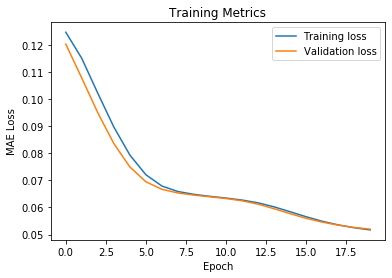

In [45]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.ylabel('MAE Loss')
plt.xlabel('Epoch')
plt.title('Training Metrics')
plt.show()

#### Model performance

Using test dataset

First lets see how well is the model doing the reconstruction for a given log

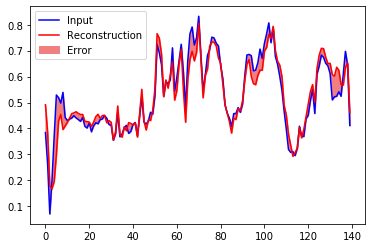

In [71]:
normal_rec = autoencoder(x_test).numpy()

log = 4
plt.plot(x_test[log], 'b')
plt.plot(normal_rec[log], 'r')
plt.fill_between(np.arange(140), normal_rec[log], x_test[log], color = 'lightcoral')
plt.legend(labels = ['Input', 'Reconstruction', 'Error'])
plt.show()

Reconstruction Error for Normal and Anomaly events over test dataset

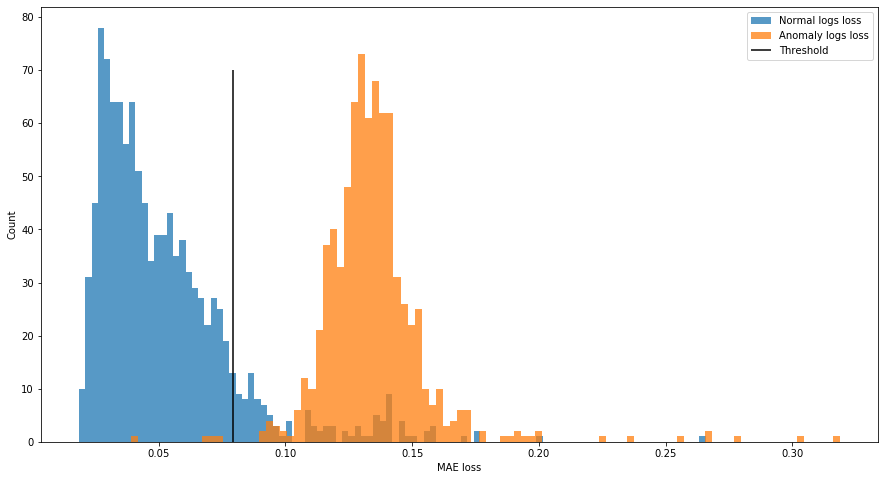

In [77]:
reconstruction_normal = autoencoder.predict(x_test_normal)
loss_normal = tf.keras.losses.mae(reconstruction_normal, x_test_normal)

reconstruction_anomaly = autoencoder.predict(x_test_anomaly)
loss_anomaly = tf.keras.losses.mae(reconstruction_anomaly, x_test_anomaly)

calculated_threshold = np.mean(loss_normal) + np.std(loss_normal)

plt.figure(figsize=(15,8))
plt.hist(loss_normal[None,:], bins = 100, alpha = 0.75, label = 'Normal logs loss')
plt.hist(loss_anomaly[None,:], bins = 100, alpha = 0.75, label = 'Anomaly logs loss')
plt.xlabel('MAE loss')
plt.ylabel('Count')
plt.vlines(calculated_threshold, 0, 70, 'k', label = 'Threshold')
plt.legend(loc = 'upper right')
plt.show()

In [65]:
x_pred = autoencoder.predict(x_test)
mae = tf.keras.losses.mae(x_pred, x_test )

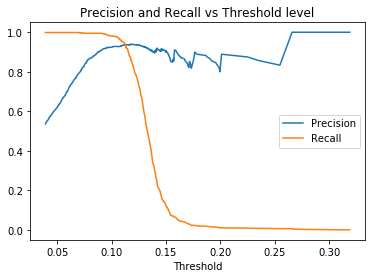

In [66]:
precision, recall, threshold = precision_recall_curve(y_test, mae)

plt.plot(threshold, precision[1:], label = 'Precision')
plt.plot(threshold, recall[1:], label = 'Recall')
plt.title('Precision and Recall vs Threshold level')
plt.xlabel('Threshold')
plt.ylabel('')
plt.xlim()
plt.legend(loc = 'center right')
plt.show()

In [67]:
threshold_val = 0.10
y_pred = [1 if e > threshold_val else 0 for e in mae]     #Prediction binarization

In [68]:
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('\nRecall: {:.2f}\n'.format(recall_score(y_test, y_pred)))


from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

Confusion Matrix

[[1056   63]
 [  15  766]]

Accuracy: 0.96


Recall: 0.98


Classification Report

              precision    recall  f1-score   support

      Normal       0.99      0.94      0.96      1119
     Anomaly       0.92      0.98      0.95       781

    accuracy                           0.96      1900
   macro avg       0.95      0.96      0.96      1900
weighted avg       0.96      0.96      0.96      1900

